In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis.convert import convert_file, root_to_numpy
from analysis.import_data import import_true_reco, reco_and_target
from analysis.mem_ana import constants
from typing import Optional
from math import ceil

sig_cross_sec = constants[f"sigma_zhh"]
bkg_cross_sec = constants[f"sigma_zzh"]

sig_to_bkg = sig_cross_sec/bkg_cross_sec # ca. 0.1

In [2]:
a = import_true_reco()#normalize=True)
#task = reco_and_target(a)
#a = a[a["passed_preselection"] == 1] # already ensured by require_preselection_pass in processor

In [3]:
len(a)

85636

In [4]:
b = pd.DataFrame(a)

In [5]:
b.to_pickle("/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/reco.pkl")

In [4]:
np.save("/nfs/dust/ilc/user/bliewert/fullflow_v3/reco.npy", a, allow_pickle=True)

In [3]:
np.count_nonzero(a["error_code"])

0

<Axes: xlabel='h2_decay_pdg', ylabel='count'>

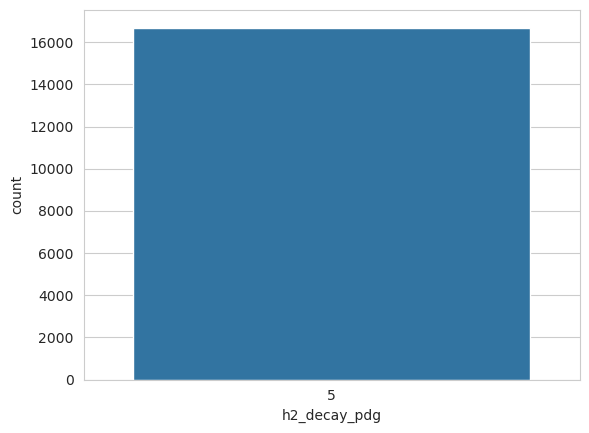

In [168]:
c = a[a["is_zzh"] == 1]
sns.countplot(a, x="h2_decay_pdg")

<Axes: xlabel='error_code', ylabel='count'>

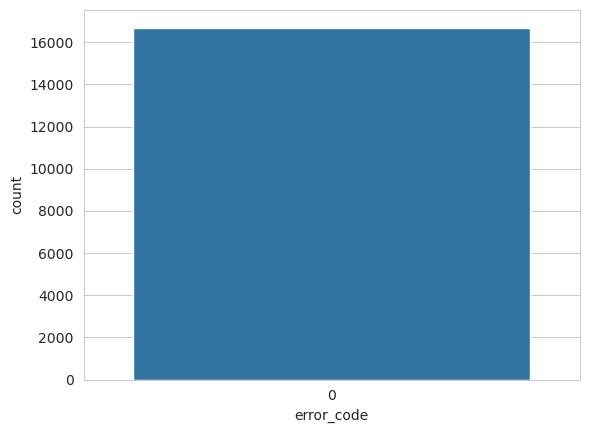

In [169]:
sns.countplot(a, x="error_code")

In [5]:
n_cols = len(features)
for col in feature_cols:
    print(n_cols - np.count_nonzero(features[col]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


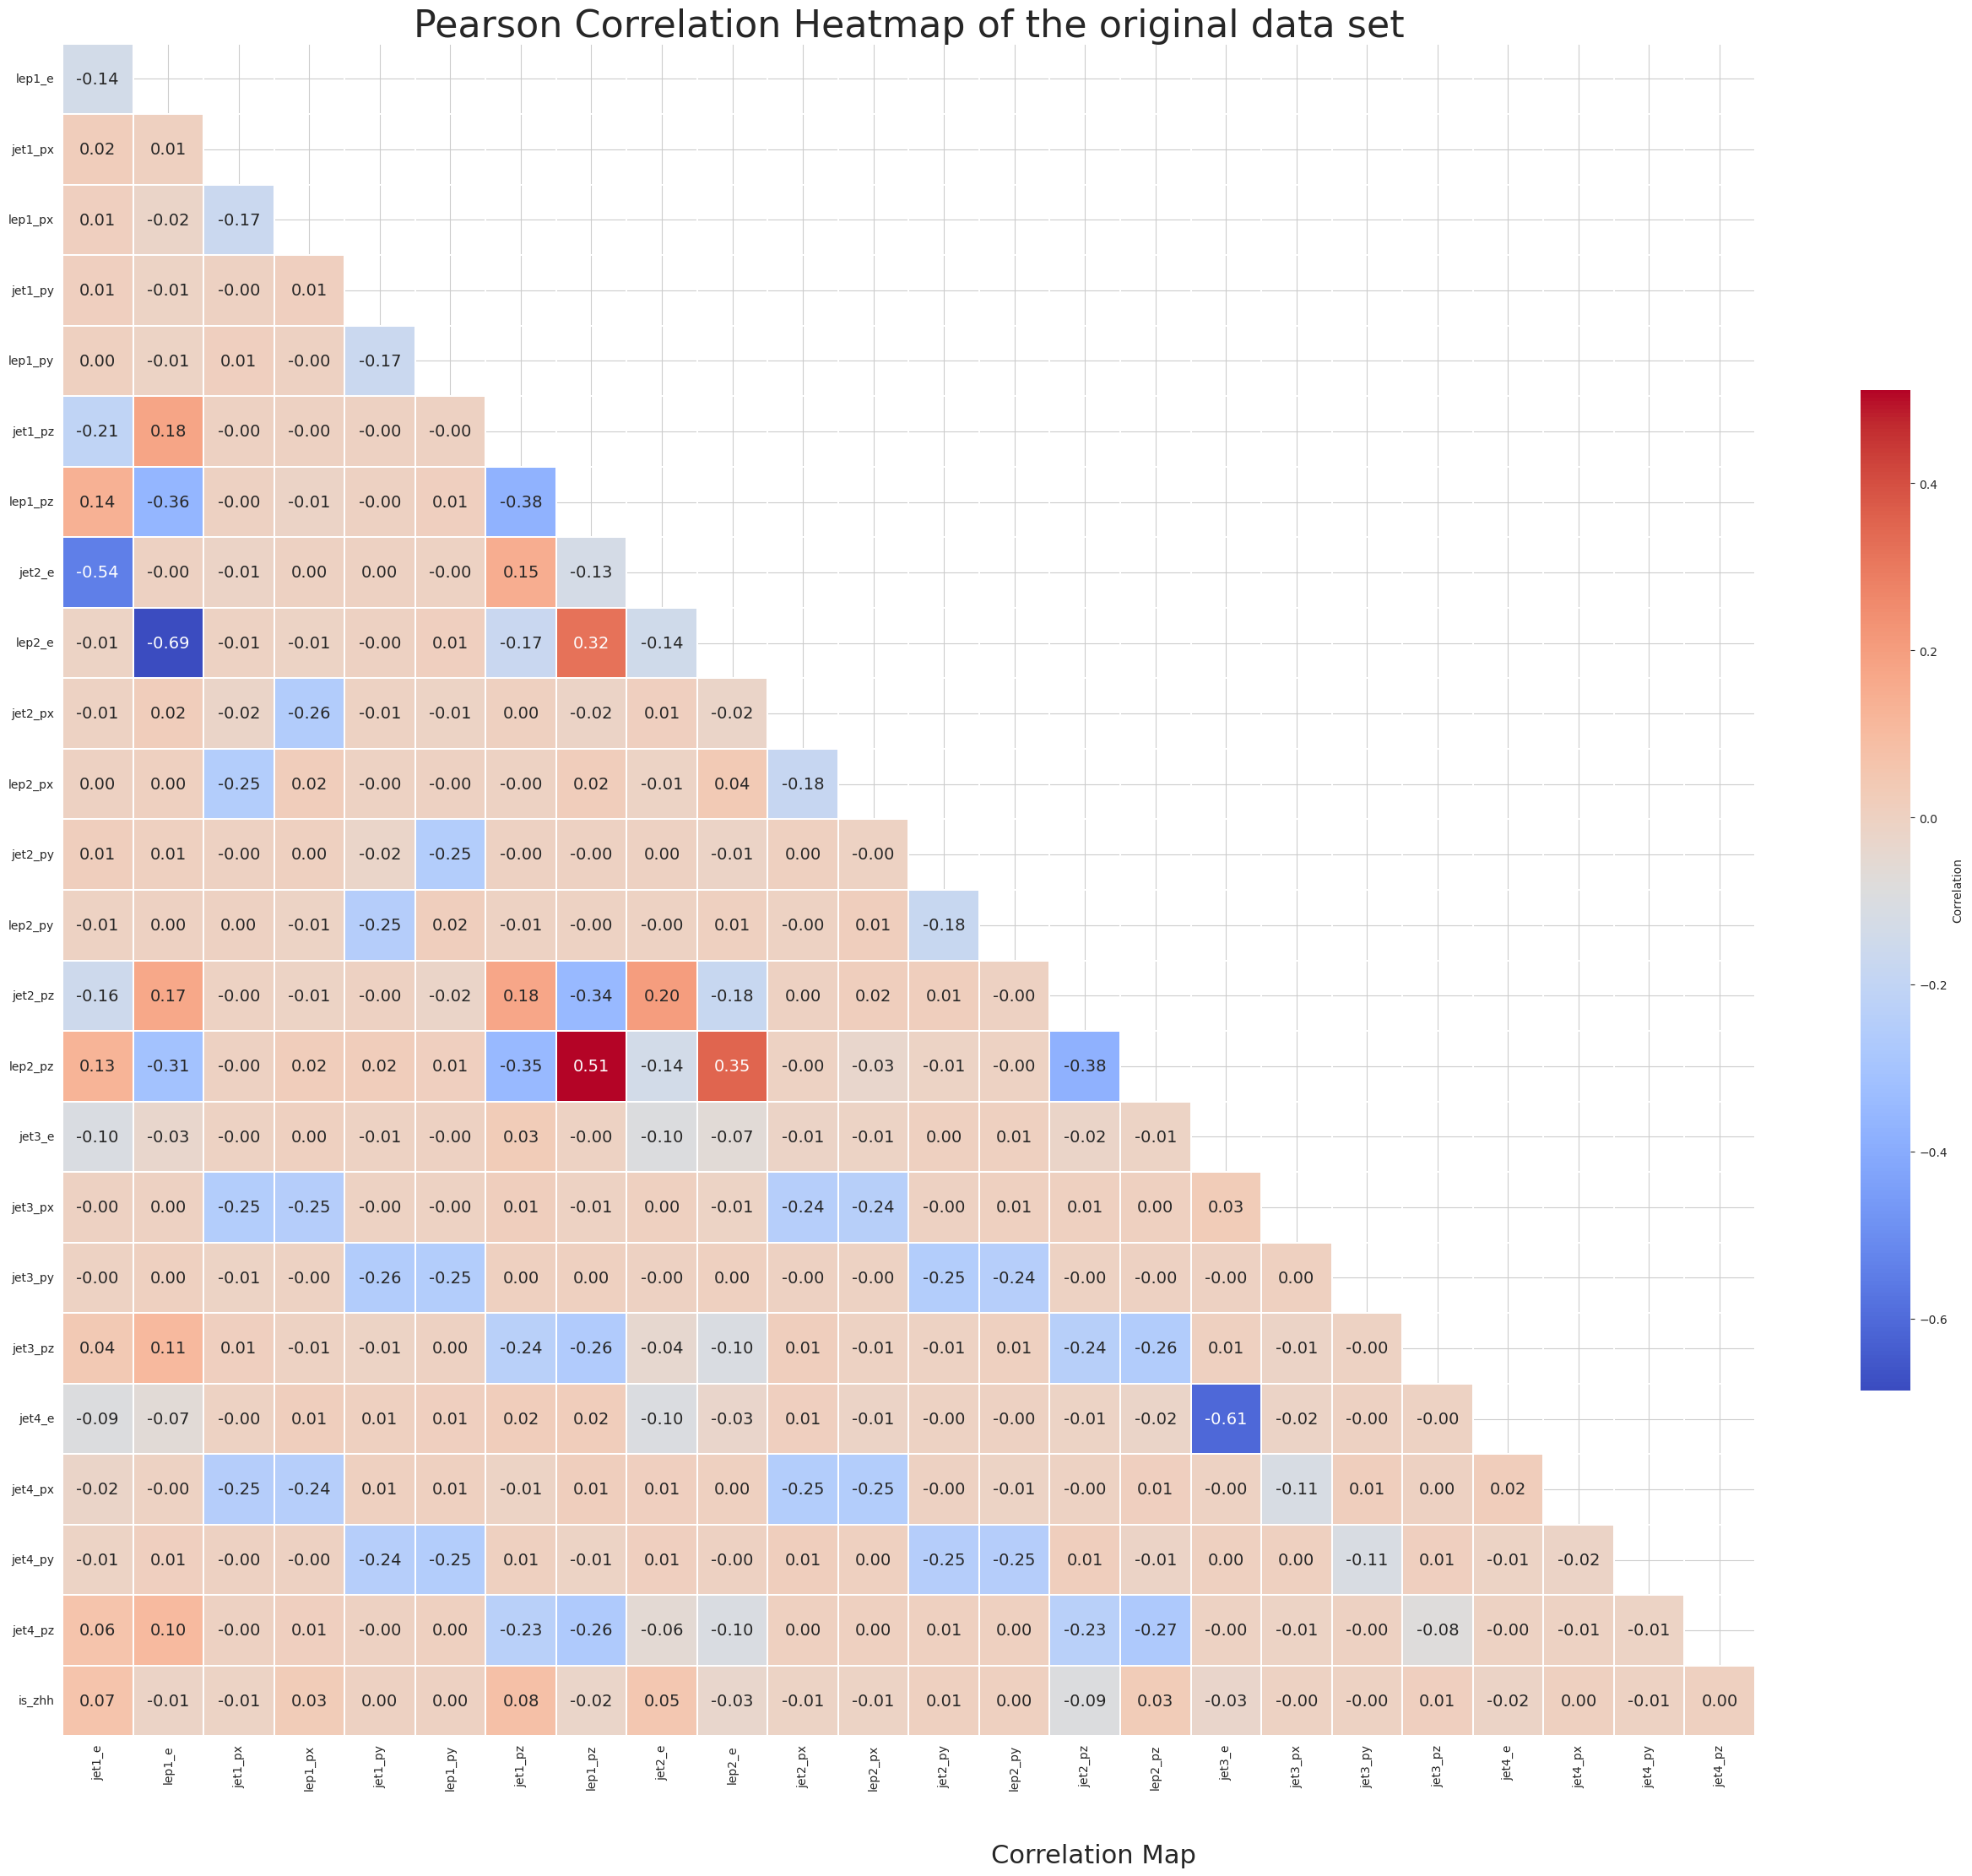

In [171]:
corr_df = task.corr()
mask = np.triu(corr_df)
mask = mask[1:, :-1]
corr_df = corr_df.iloc[1:,:-1].copy()

f,ax=plt.subplots(figsize=(26,24))
fig = sns.heatmap(corr_df,annot=True,fmt=".2f", ax=ax, 
                  linecolor="white", linewidths=0.1 ,
                  mask = mask, square=True, 
                  annot_kws={"size": 14}, cbar_kws = {"shrink":0.5, 'label': 'Correlation'},
                  cmap= 'coolwarm', rasterized=False)

plt.xticks(rotation= 90, ha = 'center')
plt.yticks(rotation= 0)

plt.title('Pearson Correlation Heatmap of the original data set', fontdict= {"fontsize":32})
plt.figtext(0.5,0.02, "Correlation Map", fontsize = 22, ha = 'center')
plt.tight_layout()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'jet1_pz'),
  Text(1, 0, 'jet1_e'),
  Text(2, 0, 'jet2_e'),
  Text(3, 0, 'lep2_pz'),
  Text(4, 0, 'lep1_px'),
  Text(5, 0, 'jet3_pz'),
  Text(6, 0, 'jet2_py'),
  Text(7, 0, 'lep2_py'),
  Text(8, 0, 'jet4_px'),
  Text(9, 0, 'jet4_pz'),
  Text(10, 0, 'lep1_py'),
  Text(11, 0, 'jet1_py'),
  Text(12, 0, 'jet3_px'),
  Text(13, 0, 'jet3_py'),
  Text(14, 0, 'jet4_py'),
  Text(15, 0, 'jet2_px'),
  Text(16, 0, 'jet1_px'),
  Text(17, 0, 'lep2_px'),
  Text(18, 0, 'lep1_e'),
  Text(19, 0, 'jet4_e'),
  Text(20, 0, 'lep1_pz'),
  Text(21, 0, 'jet3_e'),
  Text(22, 0, 'lep2_e'),
  Text(23, 0, 'jet2_pz')])

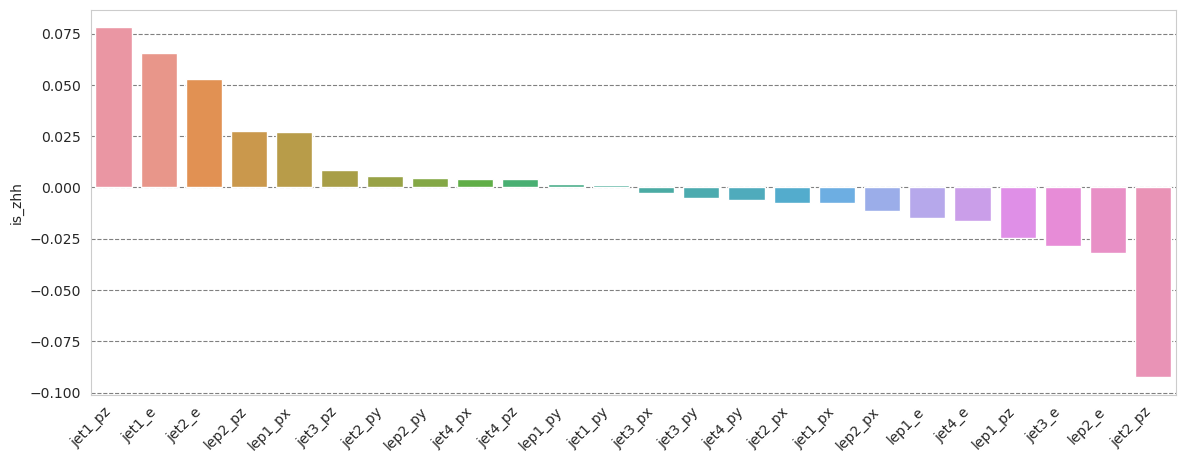

In [172]:
se_corr = task.corr()["is_zhh"].sort_values(ascending=False).iloc[1:]

fig, ax = plt.subplots(figsize=(14,5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

sns.barplot(x=se_corr.index, y=se_corr)

plt.xticks(rotation = 45, ha='right')

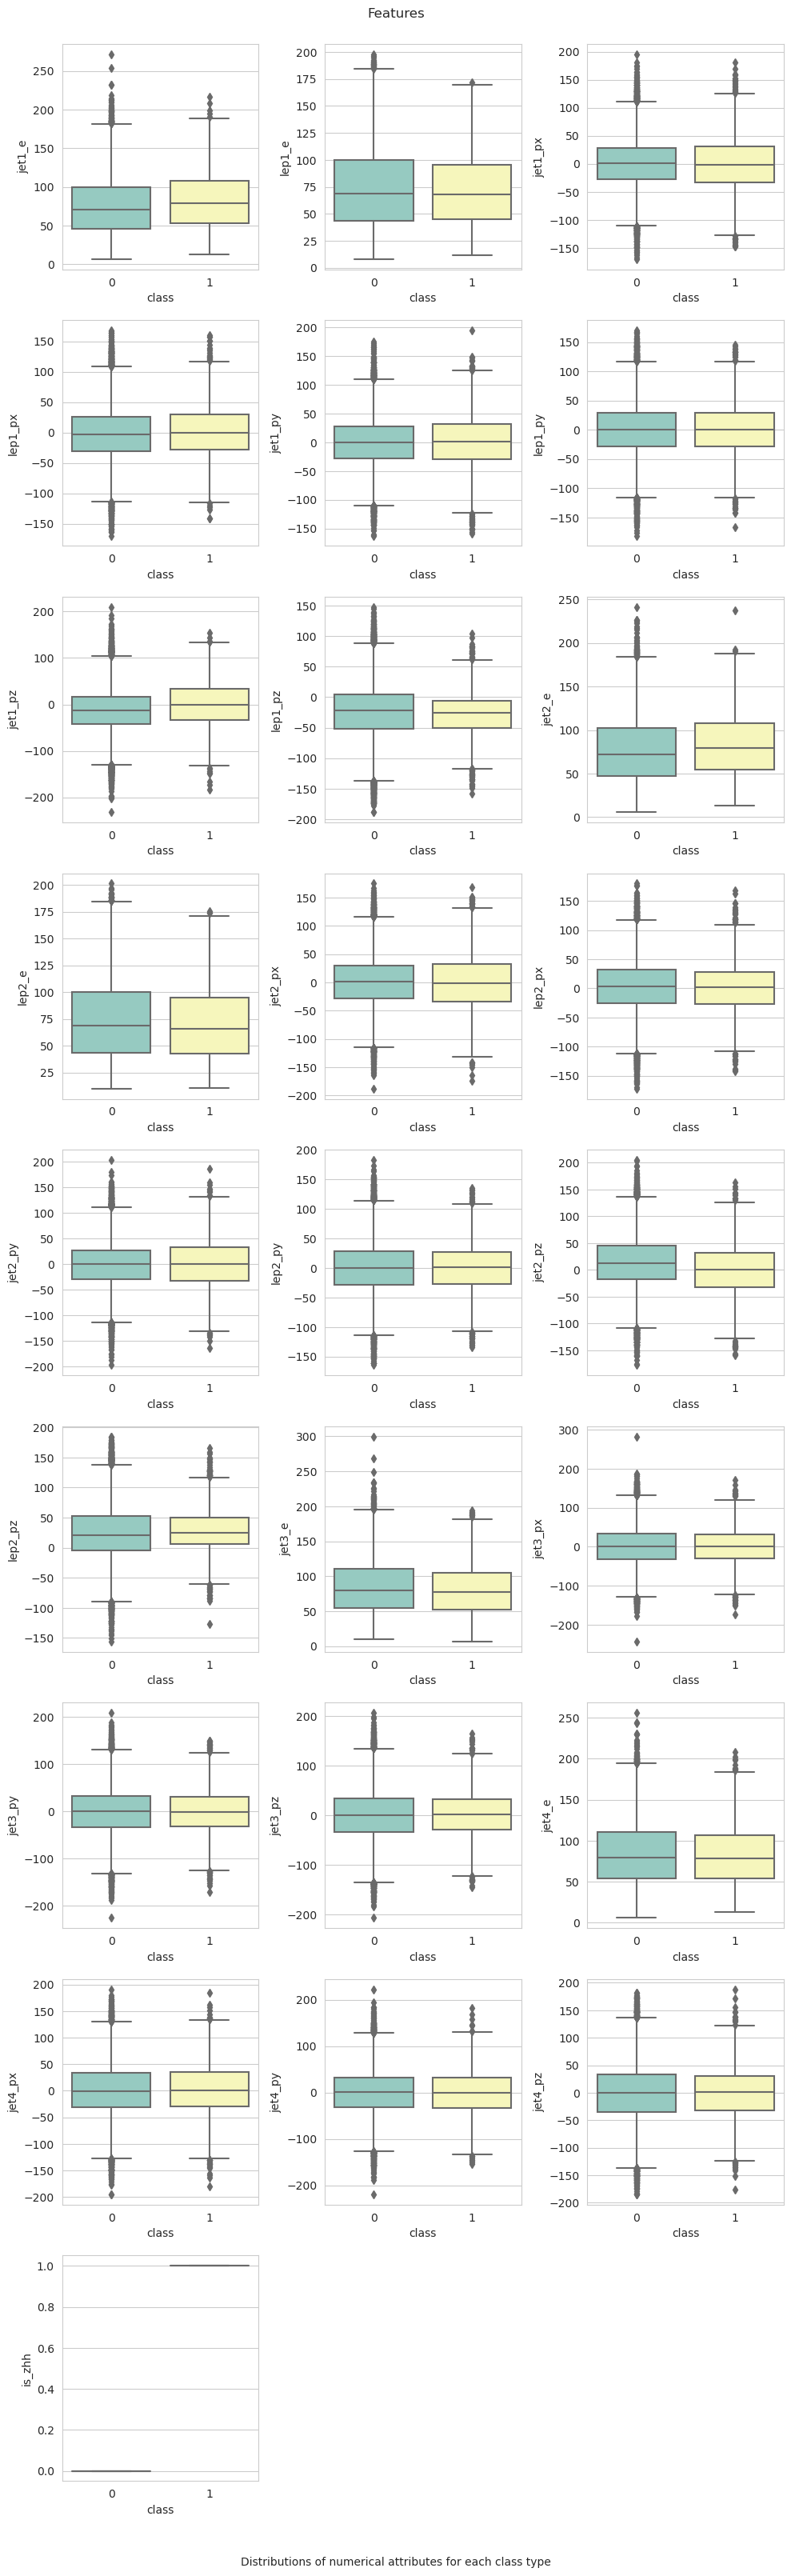

In [173]:
sns.set_style("whitegrid")

nrows = ceil(len(task.columns)/3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(10, 3.5*nrows))
fig.delaxes(axes[8, 1])
fig.delaxes(axes[8, 2])

for ax, feats in zip(axes.flatten(), task.columns):
    fig = sns.boxplot(y=feats, x = 'is_zhh', data=task, palette="Set3", ax = ax)
    ax.set_ylabel(feats)
    ax.set_xlabel('class')
    
plt.figtext(0.5,-0.015,"Distributions of numerical attributes for each class type",  ha = 'center')
plt.gcf().suptitle("Features", y=1)
plt.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=500, shuffle=True)

In [7]:
X_train.shape, X_test.shape

((16198, 24), (500, 24))

RandomForest

In [317]:
from sklearn.ensemble import RandomForestClassifier
base_model = RandomForestClassifier(random_state=1234)

In [318]:
base_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [326]:
y_test_pred = base_model.predict(X_test)
y_test_pred_prob = base_model.predict_proba(X_test)[:, 1]

In [327]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score

def report(y_true, y_pred, y_score):
    return {
        "accuracy":accuracy_score(y_true=y_true, y_pred=y_pred),
        "precision_micro_score": precision_score(y_true=y_true, y_pred=y_pred, average='micro'), # return the total ratio of tp/(tp + fp)
        "f1_micro_score": f1_score(y_true=y_true, y_pred=y_pred, average='micro'),
        "roc_auc_score":roc_auc_score(y_true=y_true, y_score=y_score, average="micro", multi_class="ovr") # One-vs-rest
    }
    
print("Test set")
report(y_test, y_test_pred, y_test_pred_prob)

Test set


{'accuracy': 0.874,
 'precision_micro_score': 0.874,
 'f1_micro_score': 0.874,
 'roc_auc_score': 0.6924376157785769}

In [331]:
from sklearn.model_selection import StratifiedKFold

param_grid = dict(
    n_estimators = [50, 100],
    # if None, then nodes are expanded until all leaves are pure or 
    # until all leaves contain less than min_samples_split samples.
    max_depth = [None, 2, 4],
#     classifier__min_samples_split = [2, 4, ],
#     classifier__min_samples_leaf = [1, 2, 3],
    # auto=sqrt, None implies max_features=n_features
    max_features = [None, "sqrt", "log2"]
)

cv = StratifiedKFold(n_splits=3)

In [332]:
import os, time
from sklearn.model_selection import GridSearchCV

n_cores=os.cpu_count()-1

classifier = RandomForestClassifier(random_state=1234)

grid_search_cv = GridSearchCV(estimator=classifier,
                              param_grid=param_grid,
                              cv=cv,
                              scoring='accuracy', 
                              n_jobs=n_cores)


In [333]:
t1 = time.time()
grid_search_cv.fit(X_train, y_train) # note: pass in the unscaled, original train set
t2 = time.time()

In [334]:
grid_search_cv.cv_results_["mean_test_score"].mean()

0.8814496975383593

In [335]:
grid_search_cv.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 100}

In [336]:
params = {k.split("__")[-1]:v for k,v in grid_search_cv.best_params_.items()}
best_model = RandomForestClassifier(random_state=1234, **params)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_features=None, random_state=1234)

In [339]:
y_test_pred_cls = best_model.predict(X_test)
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [340]:
print("Test set")
report(y_test, y_test_pred_cls, y_test_pred_prob)

Test set


{'accuracy': 0.87,
 'precision_micro_score': 0.87,
 'f1_micro_score': 0.87,
 'roc_auc_score': 0.6775997965929316}

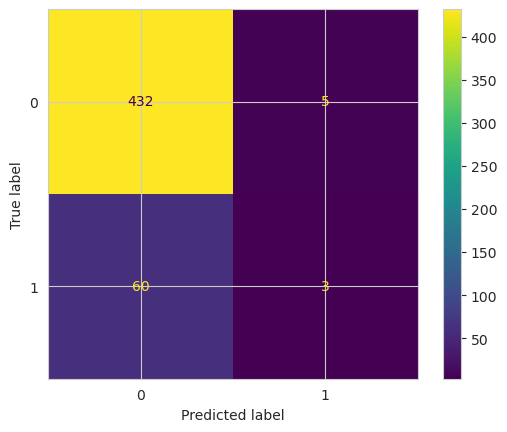

In [342]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_test_pred_cls, labels=best_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Keras Fully Connected Layer

XGBoost

In [8]:
import xgboost as xgb

In [9]:
eval_set=[(X_train, y_train), (X_test, y_test)]

In [24]:
xgb_params = dict(
        objective="binary:logistic",
        #early_stopping_rounds=10,
        #eval_metric=['error','logloss'],
        eval_metric='auc',
        random_state=2023,
        scale_pos_weight=(sig_to_bkg**-1)
)

In [25]:
xgb_clf = xgb.XGBClassifier(**xgb_params)

In [26]:
xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2023, ...)

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [14]:
def evaluate(model:xgb.XGBClassifier,
             X_train: pd.DataFrame, 
             y_train: pd.Series,
             X_test: pd.DataFrame,
             y_test: pd.Series) ->dict[str, float]:
    
    y_train_pred_cls = model.predict(X_train) 
    y_train_pred_prb = model.predict_proba(X_train)
        
    y_test_pred_cls = model.predict(X_test)
    y_test_pred_prb = model.predict_proba(X_test)    
        
    return {
        "accuracy_train": accuracy_score(y_train, y_train_pred_cls), 
        "accuracy_test": accuracy_score(y_test, y_test_pred_cls), # same as model.score(X_test,y_test)
        "roc_auc_train": roc_auc_score(y_train, y_train_pred_prb[:,1]),
        "roc_auc_test": roc_auc_score(y_test, y_test_pred_prb[:,1]),
        "f1_train": f1_score(y_train, y_train_pred_cls), 
        "f1_test": f1_score(y_test, y_test_pred_cls),
    }
    

In [15]:
def show_learning_curves(model:xgb.XGBClassifier):
    # preparing evaluation metric plots
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss']) if 'logloss' in results['validation_0'] else len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    # xgboost 'mlogloss' plot
    if 'logloss' in results['validation_0']:
        fig, ax = plt.subplots(figsize=(9,5))
        ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
        ax.legend()
        plt.ylabel('log-loss')
        plt.title('XGBoost log-loss')
        plt.show()

    # xgboost 'merror' plot
    if 'error' in results['validation_0']:
        fig, ax = plt.subplots(figsize=(9,5))
        ax.plot(x_axis, results['validation_0']['error'], label='Train')
        ax.plot(x_axis, results['validation_1']['error'], label='Test')
        ax.legend()
        plt.ylabel('error')
        plt.title('XGBoost error')
        plt.show()
        
    # xgboost 'mauc' plot
    if 'auc' in results['validation_0']:
        fig, ax = plt.subplots(figsize=(9,5))
        ax.plot(x_axis, results['validation_0']['auc'], label='Train')
        ax.plot(x_axis, results['validation_1']['auc'], label='Test')
        ax.legend()
        plt.ylabel('auc')
        plt.title('XGBoost AUC')
        plt.show()

In [16]:
datasets = dict(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [17]:
evaluate(model=xgb_clf, **datasets)

{'accuracy_train': 0.7699716014322756,
 'accuracy_test': 0.736,
 'roc_auc_train': 0.8923446084126809,
 'roc_auc_test': 0.7370986238532111,
 'f1_train': 0.4726861024624965,
 'f1_test': 0.3773584905660377}

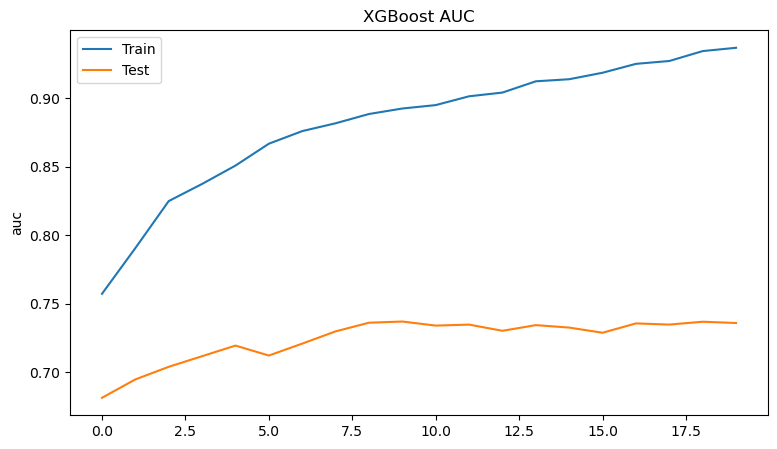

In [18]:
show_learning_curves(model=xgb_clf)

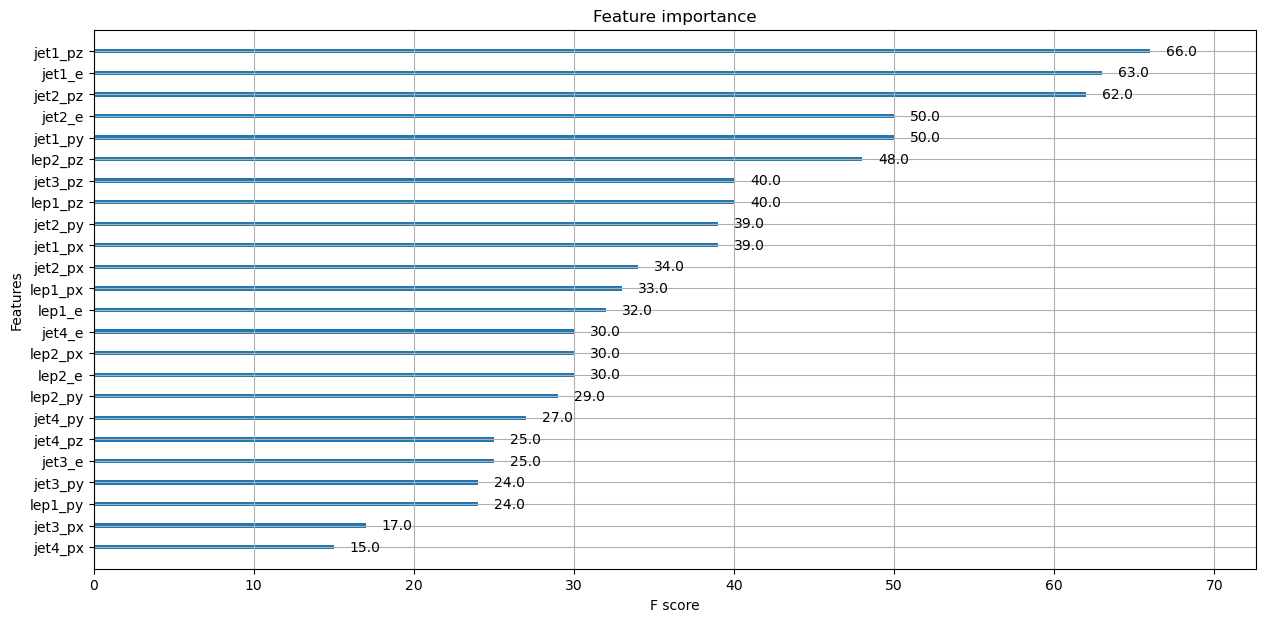

In [19]:
fig, ax=plt.subplots(figsize=(15,7))
ax=xgb.plot_importance(xgb_clf,ax=ax)
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

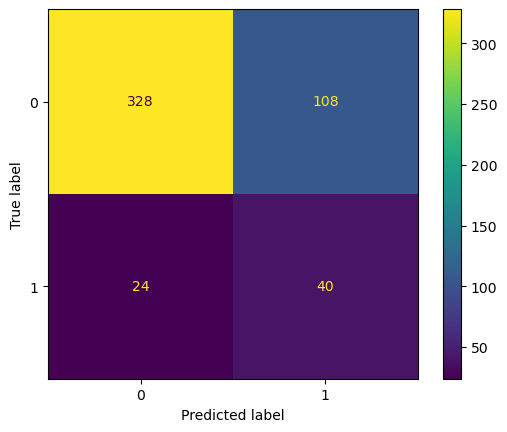

In [21]:
cm = confusion_matrix(y_test, xgb_clf.predict(X_test), labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()

In [27]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV

weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.748307 using {'scale_pos_weight': 1}
0.748307 (0.012968) with: {'scale_pos_weight': 1}
0.735745 (0.011628) with: {'scale_pos_weight': 10}
0.722056 (0.017966) with: {'scale_pos_weight': 25}
0.714621 (0.015114) with: {'scale_pos_weight': 50}
0.706360 (0.017454) with: {'scale_pos_weight': 75}
0.702902 (0.017145) with: {'scale_pos_weight': 99}
0.700970 (0.016928) with: {'scale_pos_weight': 100}
0.681115 (0.017503) with: {'scale_pos_weight': 1000}


In [307]:
# Grid search
from sklearn.model_selection import GridSearchCV
import time, os

n_cores = os.cpu_count()-1

params = {
    'n_estimators': [10, 25, 50, 100, 200],
    'max_depth': [2, 3, 5, 7, 10, 15],
    'eta': [0.1, 0.5, 1]
}

In [308]:
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(**xgb_params), param_grid=params, n_jobs=n_cores)

In [309]:
start = time.time()
grid_results = grid_search.fit(X_train, y_train, eval_set=eval_set, verbose=0)
end = time.time()
print(f"{end-start} secs")

553.2840006351471 secs


In [310]:
grid_search.best_params_

{'eta': 0.1, 'max_depth': 15, 'n_estimators': 200}

In [311]:
best_model = grid_search.best_estimator_

In [312]:
df_imp = pd.DataFrame([best_model.feature_importances_], 
                      columns=X_train.columns).T.rename({0:"importance"}, axis=1).sort_values("importance", 
                                                                                              ascending=False)

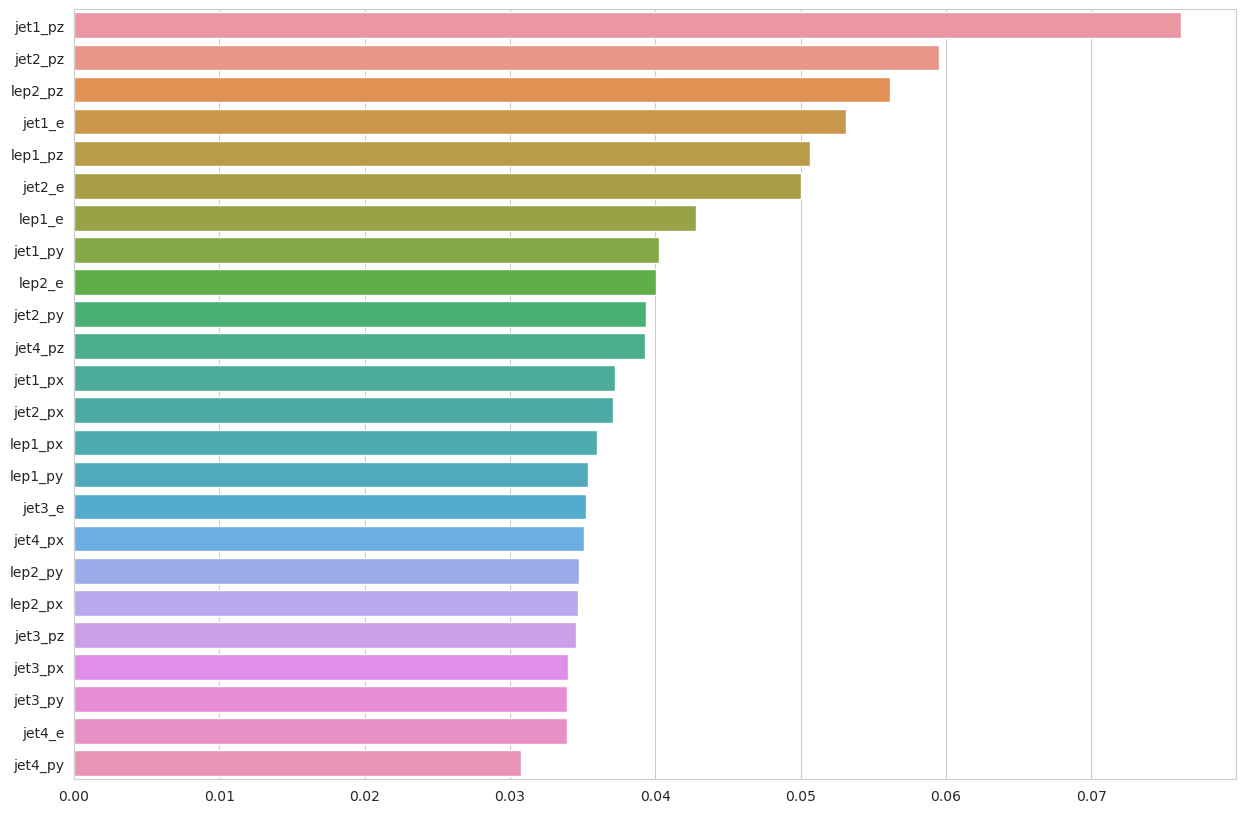

In [313]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
sns.barplot(df_imp.T, orient="h")
plt.show()

In [314]:
evaluate(model=best_model, **datasets)

{'accuracy_train': 1.0,
 'accuracy_test': 0.866,
 'roc_auc_train': 1.0,
 'roc_auc_test': 0.7482111074788419,
 'f1_train': 1.0,
 'f1_test': 0.21176470588235294}

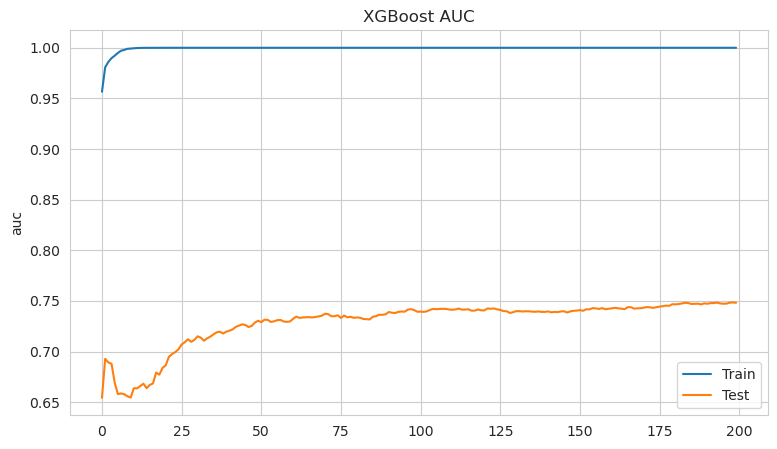

In [315]:
show_learning_curves(model=best_model)

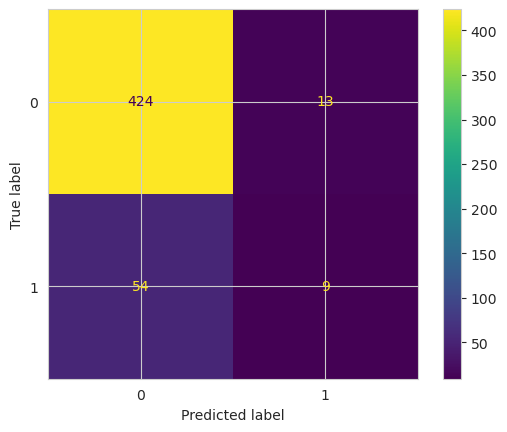

In [316]:
cm = confusion_matrix(y_test, best_model.predict(X_test), labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()